# Imports

In [48]:
import pandas as pd
import numpy as np
import xlrd
import os, sys
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import load_model
from matplotlib import pyplot
import statistics
import plotly.express as px
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, recall_score

# Data Engineering (Feature Development and Data Matching)

In [49]:
# x_dfs_names = ['X Acc', 'Y Acc', 'Z Acc', 'X Gyr', 'Y Gyr', 'Z Gyr']
# df_total = pd.DataFrame({'Time': [], 'X Acc': [], 'Y Acc': [], 'Z Acc': [], 
#                           'X Gyr': [], 'Y Gyr': [], 'Z Gyr': [],
#                           'X Jerk': [], 'Y Jerk': [], 'Z Jerk': [],
#                           'X Ang Acc': [], 'Y Ang Acc': [], 'Z Ang Acc': [], 'Labels': []})

# file_names = list(os.listdir(os.getcwd() + "/TrainingData"))
# for i in range(int(len(file_names)/4)):
#     x = pd.read_csv(os.getcwd() + "\\TrainingData\\" + file_names[4*i], names=x_dfs_names)
#     x_time = list(pd.read_csv(os.getcwd() + "\\TrainingData\\" + file_names[4*i+1], names=['Time'])['Time'])
#     y = list(pd.read_csv(os.getcwd() + "\\TrainingData\\" + file_names[4*i+2], names=['Label'])['Label'])
#     y_time = list(pd.read_csv(os.getcwd() + "\\TrainingData\\" + file_names[4*i+3], names=['Time'])['Time'])
    
#     xacc = list(x['X Acc'])
#     beef = list(x['Y Acc'])  # yacc
#     zacc = list(x['Z Acc'])
#     xgyr = list(x['X Gyr'])
#     ygyr = list(x['Y Gyr'])
#     zgyr = list(x['Z Gyr'])
    
#     xjerk = []
#     jerky = []  # yjerk
#     zjerk = []
    
#     xangacc = []
#     yangacc = []
#     zangazz = []  #zangacc
    
#     time_diff = (x_time[1]-x_time[0])
    
#     for j in range(1, len(xacc)):
#         # aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaang
#         xjerk.append((xacc[j]-xacc[j-1])/time_diff)
#         jerky.append((beef[j]-beef[j-1])/time_diff)  # derivative of beef = jerky
#         zjerk.append((zacc[j]-zacc[j-1])/time_diff)
#         xangacc.append((xgyr[j]-xgyr[j-1])/time_diff)
#         yangacc.append((ygyr[j]-ygyr[j-1])/time_diff)
#         zangazz.append((zgyr[j]-zgyr[j-1])/time_diff)
    
#     label_new = [y[0]]
#     for j in x_time[1:]:
#         if j > y_time[-1]:
#             label_new.append(y[-1])
#         else:
#             for k in range(len(y_time)-1):
#                 if j >= y_time[k] and j < y_time[k+1]:
#                     label_new.append(y[y_time.index(y_time[k])])
#                     break
#     x_new = pd.DataFrame({'X Acc': xacc[1:], 'Y Acc': beef[1:], 'Z Acc': zacc[1:], 
#                           'X Gyr': xgyr[1:], 'Y Gyr': ygyr[1:], 'Z Gyr': zgyr[1:],
#                           'X Jerk': xjerk, 'Y Jerk': jerky, 'Z Jerk': zjerk,
#                           'X Ang Acc': xangacc, 'Y Ang Acc': yangacc, 'Z Ang Acc': zangazz})
#     time_df = pd.DataFrame({'Time': x_time[1:]})
#     label_df = pd.DataFrame({'Labels': label_new[1:]})
#     df_trial = pd.concat([time_df, x_new, label_df], axis=1)
#     df_total = pd.concat([df_total, df_trial], axis=0).reset_index(drop=True)
#     print('Done with Trial: ', i)
# df_total.to_csv('Concat_Data.csv')

df_total = pd.read_csv(os.getcwd() + '/Concat_Data.csv', 
                       usecols=['Time', 'X Acc', 'Y Acc', 'Z Acc', 'X Gyr', 'Y Gyr', 'Z Gyr', 
                                'X Jerk', 'Y Jerk', 'Z Jerk', 'X Ang Acc', 'Y Ang Acc', 
                                'Z Ang Acc', 'Labels'])
df_total

,Time,X Acc,Y Acc,Z Acc,X Gyr,Y Gyr,Z Gyr,X Jerk,Y Jerk,Z Jerk,X Ang Acc,Y Ang Acc,Z Ang Acc,Labels
0,0.025,4.186920,8.344455,2.908057,0.005771,-0.004480,-0.003345,-9.93420,5.93568,-2.65724,-0.337779,1.387096,0.535974,0.0
1,0.050,4.544637,8.408659,2.890000,0.007967,0.022412,0.001159,14.30868,2.56816,-0.72228,0.087867,1.075656,0.180142,0.0
2,0.075,4.849308,8.411614,2.900692,0.027778,-0.010670,-0.014223,12.18684,0.11820,0.42768,0.792414,-1.323285,-0.615262,0.0
3,0.100,4.509190,8.118649,2.847298,0.021577,-0.045498,-0.021111,-13.60472,-11.71860,-2.13576,-0.248033,-1.393120,-0.275524,0.0
4,0.125,4.226515,8.273807,2.851742,0.012534,0.000445,-0.016830,-11.30700,6.20632,0.17776,-0.361738,1.837744,0.171264,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1341612,1203.325,2.072244,8.908878,-3.500000,0.001351,0.001191,0.001031,-1.04228,0.61920,0.40000,0.006233,0.034226,0.000158,0.0
1341613,1203.350,2.085123,8.915123,-3.520000,0.001918,-0.001147,0.000000,0.51516,0.24980,-0.80000,0.022683,-0.093503,-0.041249,0.0
1341614,1203.375,2.083774,8.910000,-3.538981,-0.002015,-0.004099,0.001042,-0.05396,-0.20492,-0.75924,-0.157323,-0.118115,0.041684,0.0
1341615,1203.400,2.111447,8.908553,-3.535724,0.000183,-0.001673,0.001856,1.10692,-0.05788,0.13028,0.087935,0.097066,0.032553,0.0


In [50]:
X = df_total[['X Acc', 'Y Acc', 'Z Acc', 'X Gyr', 'Y Gyr', 'Z Gyr', 
              'X Jerk', 'Y Jerk', 'Z Jerk', 'X Ang Acc', 'Y Ang Acc', 
              'Z Ang Acc']]
# X = df_total[['X Acc', 'Y Acc', 'Z Acc', 'X Gyr', 'Y Gyr', 'Z Gyr']]
y = df_total[['Labels']].squeeze()

# Normalizing Data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
X_scaled = pd.DataFrame(sc.fit_transform(X))
X_scaled.columns = ['X Acc', 'Y Acc', 'Z Acc', 'X Gyr', 'Y Gyr', 'Z Gyr', 
              'X Jerk', 'Y Jerk', 'Z Jerk', 'X Ang Acc', 'Y Ang Acc', 
              'Z Ang Acc']

print(X_scaled)
print(y.head())

            X Acc     Y Acc     Z Acc     X Gyr     Y Gyr     Z Gyr    X Jerk  \
0        0.551775  0.603074  0.486524  0.512318  0.498089  0.474741  0.482030   
1        0.556330  0.603893  0.486268  0.512414  0.499188  0.475033  0.486270   
2        0.560209  0.603930  0.486420  0.513287  0.497836  0.474035  0.485899   
3        0.555878  0.600197  0.485665  0.513014  0.496414  0.473588  0.481388   
4        0.552279  0.602174  0.485727  0.512616  0.498291  0.473866  0.481790   
...           ...       ...       ...       ...       ...       ...       ...   
1341612  0.524851  0.610267  0.395916  0.512123  0.498321  0.475025  0.483586   
1341613  0.525015  0.610347  0.395633  0.512148  0.498225  0.474958  0.483858   
1341614  0.524997  0.610281  0.395364  0.511975  0.498105  0.475025  0.483758   
1341615  0.525350  0.610263  0.395411  0.512072  0.498204  0.475078  0.483961   
1341616  0.525048  0.610154  0.395649  0.512066  0.498221  0.474958  0.483602   

           Y Jerk    Z Jerk

In [51]:
sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X_scaled, y)

print(f'''Shape of X before SMOTE: {X_scaled.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (1341617, 12)
Shape of X after SMOTE: (4027588, 12)

Balance of positive and negative classes (%):


1.0    25.0
3.0    25.0
2.0    25.0
0.0    25.0
Name: Labels, dtype: float64

In [52]:
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(y_sm.to_frame()).toarray())
enc_df.columns = ['Solid', 'Downstairs', 'Upstairs', 'Grass']
y_final = enc_df
print(X_scaled.head())
print(y_final.head())

      X Acc     Y Acc     Z Acc     X Gyr     Y Gyr     Z Gyr    X Jerk  \
0  0.551775  0.603074  0.486524  0.512318  0.498089  0.474741  0.482030   
1  0.556330  0.603893  0.486268  0.512414  0.499188  0.475033  0.486270   
2  0.560209  0.603930  0.486420  0.513287  0.497836  0.474035  0.485899   
3  0.555878  0.600197  0.485665  0.513014  0.496414  0.473588  0.481388   
4  0.552279  0.602174  0.485727  0.512616  0.498291  0.473866  0.481790   

     Y Jerk    Z Jerk  X Ang Acc  Y Ang Acc  Z Ang Acc  
0  0.494890  0.509048   0.610230   0.462129   0.505502  
1  0.494344  0.509439   0.610590   0.461851   0.504873  
2  0.493946  0.509671   0.611185   0.459714   0.503467  
3  0.492027  0.509154   0.610306   0.459652   0.504068  
4  0.494934  0.509620   0.610210   0.462531   0.504857  
   Solid  Downstairs  Upstairs  Grass
0    1.0         0.0       0.0    0.0
1    1.0         0.0       0.0    0.0
2    1.0         0.0       0.0    0.0
3    1.0         0.0       0.0    0.0
4    1.0         

## Random Forest

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm_final, test_size=0.25, random_state=42
)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [ ]:
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}')
rs = recall_score(y_test, preds, average='samples')
print(f'Recall = {rs:.2f}')

## Neural Networks

In [53]:
# Defining Additional Swish Activation Function
from tensorflow.keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

### Simple DNN Model

In [54]:
# Define Additional Constants
num_inputs = 12
print(X_scaled)
print(y_final)
X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_final, test_size=0.25, random_state=42
)
# X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
# X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
# y_train = y_train.values
# y_test = y_test.values

# # Create a pd.series that represents the categorical class of each one-hot encoded row
# y_classes = pd.DataFrame(y_train).idxmax(1, skipna=False)

# from sklearn.preprocessing import LabelEncoder

# # Instantiate the label encoder
# le = LabelEncoder()

# # Fit the label encoder to our label series
# le.fit(list(y_classes))

# # Create integer based labels Series
# y_integers = le.transform(list(y_classes))

# # Create dict of labels : integer representation
# labels_and_integers = dict(zip(y_classes, y_integers))

# from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

# class_weights = compute_class_weight('balanced', np.unique(np.array(y_train)), np.array(y_train))
# class_weights = {i : class_weights[i] for i in range(4)}
# sample_weights = compute_sample_weight('balanced', y_integers)

            X Acc     Y Acc     Z Acc     X Gyr     Y Gyr     Z Gyr    X Jerk  \
0        0.551775  0.603074  0.486524  0.512318  0.498089  0.474741  0.482030   
1        0.556330  0.603893  0.486268  0.512414  0.499188  0.475033  0.486270   
2        0.560209  0.603930  0.486420  0.513287  0.497836  0.474035  0.485899   
3        0.555878  0.600197  0.485665  0.513014  0.496414  0.473588  0.481388   
4        0.552279  0.602174  0.485727  0.512616  0.498291  0.473866  0.481790   
...           ...       ...       ...       ...       ...       ...       ...   
1341612  0.524851  0.610267  0.395916  0.512123  0.498321  0.475025  0.483586   
1341613  0.525015  0.610347  0.395633  0.512148  0.498225  0.474958  0.483858   
1341614  0.524997  0.610281  0.395364  0.511975  0.498105  0.475025  0.483758   
1341615  0.525350  0.610263  0.395411  0.512072  0.498204  0.475078  0.483961   
1341616  0.525048  0.610154  0.395649  0.512066  0.498221  0.474958  0.483602   

           Y Jerk    Z Jerk

In [55]:
# print(class_weights)
print(y_train)

         Solid  Downstairs  Upstairs  Grass
507503     1.0         0.0       0.0    0.0
3949485    0.0         0.0       0.0    1.0
1869277    0.0         1.0       0.0    0.0
1051375    1.0         0.0       0.0    0.0
2465115    0.0         0.0       1.0    0.0
...        ...         ...       ...    ...
2356330    0.0         0.0       1.0    0.0
3511566    0.0         0.0       0.0    1.0
2229084    0.0         1.0       0.0    0.0
2768307    0.0         0.0       1.0    0.0
2219110    0.0         1.0       0.0    0.0

[3020691 rows x 4 columns]


In [56]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Epoch 1/30
2950/2950 - 46s - loss: 1.0071 - categorical_accuracy: 0.5395 - acc: 0.5395 - f1_m: 0.4223 - precision_m: 0.6278 - recall_m: 0.3354 - val_loss: 0.7826 - val_categorical_accuracy: 0.6586 - val_acc: 0.6586 - val_f1_m: 0.6192 - val_precision_m: 0.7440 - val_recall_m: 0.5304
Epoch 2/30
2950/2950 - 56s - loss: 0.6934 - categorical_accuracy: 0.7020 - acc: 0.7020 - f1_m: 0.6808 - precision_m: 0.7666 - recall_m: 0.6129 - val_loss: 0.6519 - val_categorical_accuracy: 0.7222 - val_acc: 0.7222 - val_f1_m: 0.7052 - val_precision_m: 0.7810 - val_recall_m: 0.6429
Epoch 3/30
2950/2950 - 44s - loss: 0.6013 - categorical_accuracy: 0.7442 - acc: 0.7442 - f1_m: 0.7334 - precision_m: 0.7905 - recall_m: 0.6841 - val_loss: 0.5810 - val_categorical_accuracy: 0.7540 - val_acc: 0.7540 - val_f1_m: 0.7458 - val_precision_m: 0.7981 - val_recall_m: 0.7000
Epoch 4/30
2950/2950 - 41s - loss: 0.5541 - categorical_accuracy: 0.7657 - acc: 0.7657 - f1_m: 0.7583 - precision_m: 0.8036 - recall_m: 0.7180 - val_lo

Epoch 30/30
2950/2950 - 66s - loss: 0.3733 - categorical_accuracy: 0.8438 - acc: 0.8438 - f1_m: 0.8428 - precision_m: 0.8588 - recall_m: 0.8274 - val_loss: 0.3813 - val_categorical_accuracy: 0.8424 - val_acc: 0.8424 - val_f1_m: 0.8413 - val_precision_m: 0.8582 - val_recall_m: 0.8251


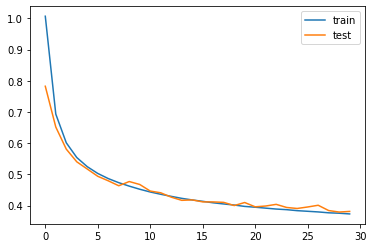

In [57]:
model = Sequential()
model.add(Dense(num_inputs, input_dim=num_inputs))
model.add(Dense(200, activation='swish'))
model.add(Dense(200, activation='swish'))
model.add(Dense(200, activation='swish'))
model.add(Dense(200, activation='swish'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['categorical_accuracy','acc',f1_m,precision_m, recall_m])
history = model.fit(X_train, y_train, epochs=30, batch_size=1024, validation_data=(X_test, y_test), 
                    verbose=2, shuffle=True)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

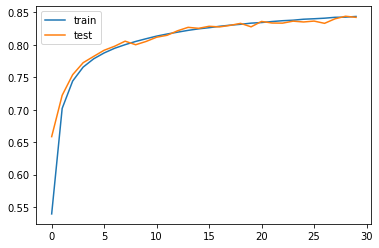

In [59]:
pyplot.plot(history.history['categorical_accuracy'], label='train')
pyplot.plot(history.history['val_categorical_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [65]:
print(X_test.shape)

(1006897, 12)


In [91]:
from sklearn.metrics import confusion_matrix,classification_report

y_pred = model.predict(X_test,verbose=1,batch_size=1024)

984/984 [==============================] - 14s 14ms/step


In [92]:
print(np.array(y_test)[0,:])

[0. 0. 0. 1.]


In [93]:
y_pred_int = []
y_test_int = []
y_test_array = np.array(y_test)

for i in range(0, len(y_pred)):
    y_pred_int.append(np.argmax(y_pred[i]))
    y_test_int.append(np.argmax(y_test_array[i,:]))

#Get the confusion matrix
cm = confusion_matrix(y_test_int, y_pred_int)

#Now the normalize the diagonal entries
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#The diagonal entries are the accuracies of each class
cm.diagonal()

array([0.69395898, 0.94148812, 0.96737782, 0.76607957])

In [94]:
target_names = ['class 0', 'class 1', 'class 2','class 3']
print(classification_report(y_test_int, y_pred_int, target_names=target_names, digits=4))

              precision    recall  f1-score   support

     class 0     0.7450    0.6940    0.7186    251133
     class 1     0.9294    0.9415    0.9354    251795
     class 2     0.9531    0.9674    0.9602    252221
     class 3     0.7364    0.7661    0.7510    251748

    accuracy                         0.8424   1006897
   macro avg     0.8410    0.8422    0.8413   1006897
weighted avg     0.8411    0.8424    0.8414   1006897



In [ ]:
# evaluate the model
loss, categorical_acc, accuracy, f1_score, precision, recall = model.evaluate(x=X_test, y=y_test)

In [27]:
model.save('Basic_FFNN')

INFO:tensorflow:Assets written to: Basic_FFNN\assets


INFO:tensorflow:Assets written to: Basic_FFNN\assets


### LSTM Model

In [22]:
timestep = 1 # seconds
num_points = 1341617
train_test_split = 100528
X_train = []
y_train = []
X_test = []
y_test = []
X_scaled = np.array(X_scaled)
y_final = np.array(y_final)
# for i in range(timestep*40, train_test_split):
#     X_train.append(X_scaled[i-timestep*40:i, :])
#     y_train.append(y_final[i, :])
# X_train, y_train = np.array(X_train), np.array(y_train)
# for i in range(train_test_split+timestep*40, num_points):
#     X_test.append(X_scaled[i-timestep*40:i, :])
#     y_test.append(y_final[i, :])
X_test, y_test, X_train, y_train = np.array(X_scaled)[0:train_test_split-1], \
                                   np.array(y_final)[0:train_test_split-1], \
                                   np.array(X_scaled)[train_test_split:num_points], \
                                   np.array(y_final)[train_test_split:num_points]

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_train = np.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1]))
y_test = np.reshape(y_test, (y_test.shape[0], 1, y_test.shape[1]))

In [23]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1241089, 1, 12)
(1241089, 1, 4)
(100527, 1, 12)
(100527, 1, 4)


Epoch 1/30
1213/1213 - 9s - loss: 0.1464 - categorical_accuracy: 0.7537 - acc: 0.7537 - f1_m: 0.2799 - precision_m: 0.3861 - recall_m: 0.2564 - val_loss: 0.1716 - val_categorical_accuracy: 0.7008 - val_acc: 0.7008 - val_f1_m: 0.7033 - val_precision_m: 0.7033 - val_recall_m: 0.7033
Epoch 2/30
1213/1213 - 5s - loss: 0.1454 - categorical_accuracy: 0.7533 - acc: 0.7533 - f1_m: 0.2675 - precision_m: 0.2827 - recall_m: 0.2652 - val_loss: 0.1713 - val_categorical_accuracy: 0.7008 - val_acc: 0.7008 - val_f1_m: 0.7033 - val_precision_m: 0.7033 - val_recall_m: 0.7033
Epoch 3/30
1213/1213 - 5s - loss: 0.1454 - categorical_accuracy: 0.7529 - acc: 0.7529 - f1_m: 0.2709 - precision_m: 0.2742 - recall_m: 0.2700 - val_loss: 0.1712 - val_categorical_accuracy: 0.7008 - val_acc: 0.7008 - val_f1_m: 0.7033 - val_precision_m: 0.7033 - val_recall_m: 0.7033
Epoch 4/30
1213/1213 - 6s - loss: 0.1454 - categorical_accuracy: 0.7545 - acc: 0.7545 - f1_m: 0.2715 - precision_m: 0.2741 - recall_m: 0.2709 - val_loss: 

Epoch 30/30
1213/1213 - 8s - loss: 0.1454 - categorical_accuracy: 0.7545 - acc: 0.7545 - f1_m: 0.2708 - precision_m: 0.2708 - recall_m: 0.2708 - val_loss: 0.1711 - val_categorical_accuracy: 0.7008 - val_acc: 0.7008 - val_f1_m: 0.7033 - val_precision_m: 0.7033 - val_recall_m: 0.7033


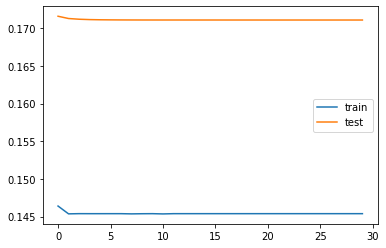

In [27]:
model = Sequential()
model.add(LSTM(40, return_sequences=True))
# model.add(LSTM(40, return_sequences=True))
# model.add(LSTM(200, activation='swish', return_sequences=True))
model.add(Dropout(0.3))
# model.add(Dense(200))
# model.add(BatchNormalization())
# model.add(Activation('swish'))
# model.add(Dense(200))
# model.add(BatchNormalization())
# model.add(Activation('swish'))
# model.add(Dense(200))
# model.add(BatchNormalization())
# model.add(Activation('swish'))
# model.add(Dense(200, activation='swish'))
# model.add(Dense(200, activation='swish'))
# model.add(Dense(200, activation='swish'))
model.add(TimeDistributed(Dense(4, activation='softmax')))

model.compile(loss=SigmoidFocalCrossEntropy(), optimizer=Adam(learning_rate=0.01), metrics=['categorical_accuracy','acc',f1_m,precision_m, recall_m])
history = model.fit(X_train, y_train, epochs=30, batch_size=1024, validation_data=(X_test, y_test), verbose=2, shuffle=False)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [28]:
# evaluate the model
loss, categorical_acc, accuracy, f1_score, precision, recall = model.evaluate(x=X_test, y=y_test)

3142/3142 [==============================] - 11s 3ms/step - loss: 0.1709 - categorical_accuracy: 0.7008 - acc: 0.7008 - f1_m: 0.7008 - precision_m: 0.7008 - recall_m: 0.7008


# Getting Output from Model
## Input Data Preparation

In [3]:
model = load_model('Basic_FFNN')

In [46]:
x_dfs_names = ['X Acc', 'Y Acc', 'Z Acc', 'X Gyr', 'Y Gyr', 'Z Gyr']
df_test_total = pd.DataFrame({'Time': [], 'X Acc': [], 'Y Acc': [], 'Z Acc': [], 
                          'X Gyr': [], 'Y Gyr': [], 'Z Gyr': [],
                          'X Jerk': [], 'Y Jerk': [], 'Z Jerk': [],
                          'X Ang Acc': [], 'Y Ang Acc': [], 'Z Ang Acc': [], 'Labels': []})

file_names = list(os.listdir(os.getcwd() + "/TestData"))
# for i in range(int(len(file_names)/3)):
for i in range(3, 4):
    x = pd.read_csv(os.getcwd() + "\\TestData\\" + file_names[3*i], names=x_dfs_names)
    x_time = list(pd.read_csv(os.getcwd() + "\\TestData\\" + file_names[3*i+1], names=['Time'])['Time'])
    y_time = list(pd.read_csv(os.getcwd() + "\\TestData\\" + file_names[3*i+2], names=['Time'])['Time'])
    
    xacc = list(x['X Acc'])
    beef = list(x['Y Acc'])  # yacc
    zacc = list(x['Z Acc'])
    xgyr = list(x['X Gyr'])
    ygyr = list(x['Y Gyr'])
    zgyr = list(x['Z Gyr'])
    
    xjerk = []
    jerky = []  # yjerk
    zjerk = []
    
    xangacc = []
    yangacc = []
    zangazz = []  #zangacc
    
    time_diff = (x_time[1]-x_time[0])
    
    for j in range(1, len(xacc)):
        # aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaang
        xjerk.append((xacc[j]-xacc[j-1])/time_diff)
        jerky.append((beef[j]-beef[j-1])/time_diff)  # derivative of beef = jerky
        zjerk.append((zacc[j]-zacc[j-1])/time_diff)
        xangacc.append((xgyr[j]-xgyr[j-1])/time_diff)
        yangacc.append((ygyr[j]-ygyr[j-1])/time_diff)
        zangazz.append((zgyr[j]-zgyr[j-1])/time_diff)
    
#     label_new = [y[0]]
#     for j in x_time[1:]:
#         if j > y_time[-1]:
#             label_new.append(y[-1])
#         else:
#             for k in range(len(y_time)-1):
#                 if j >= y_time[k] and j < y_time[k+1]:
#                     label_new.append(y[y_time.index(y_time[k])])
#                     break

    x_new = pd.DataFrame({'X Acc': xacc[1:], 'Y Acc': beef[1:], 'Z Acc': zacc[1:], 
                          'X Gyr': xgyr[1:], 'Y Gyr': ygyr[1:], 'Z Gyr': zgyr[1:],
                          'X Jerk': xjerk, 'Y Jerk': jerky, 'Z Jerk': zjerk,
                          'X Ang Acc': xangacc, 'Y Ang Acc': yangacc, 'Z Ang Acc': zangazz})
    
    sc = MinMaxScaler(feature_range = (0, 1))
    X_new_scaled = pd.DataFrame(sc.fit_transform(x_new))
    X_new_scaled.columns = ['X Acc', 'Y Acc', 'Z Acc', 'X Gyr', 'Y Gyr', 'Z Gyr', 
                  'X Jerk', 'Y Jerk', 'Z Jerk', 'X Ang Acc', 'Y Ang Acc', 
                  'Z Ang Acc']
    X_new_scaled = np.array(X_new_scaled)
#     print(x_new.shape[0])
    expected_list = []
    for j in range(X_new_scaled.shape[0]):
        row = np.reshape(X_new_scaled[j,:], (1, 1, 12))
#         print(row.shape)
#         print(row)
        expected = model.predict(row)
#         print(expected)
        exp_class = np.argmax(expected)
        print(exp_class)
        expected_list.append(exp_class)
#     expected_list = model.predict(x_new)
#     print(expected_list)
        
#     time_df = pd.DataFrame({'Time': x_time[1:]})
#     label_df = pd.DataFrame({'Labels': label_new[1:]})
#     df_trial = pd.concat([time_df, x_new, label_df], axis=1)
#     df_total = pd.concat([df_total, df_trial], axis=0).reset_index(drop=True)
#     print('Done with Trial: ', i)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


KeyboardInterrupt: 

In [ ]:
expected_list_new = [expected_list[0]] + expected_list
len(expected_list_new)
down_sampled_y = []
# x_time = list(pd.read_csv(os.getcwd() + "\\TestData\\" + file_names[7], names=['Time'])['Time'])
# y_time = list(pd.read_csv(os.getcwd() + "\\TestData\\" + file_names[8], names=['Time'])['Time'])

from collections import Counter 
  
def most_frequent(List): 
    occurence_count = Counter(List) 
    return occurence_count.most_common(1)[0][0] 


for i in range(len(y_time)-1):
    y_time_output = y_time[i]
#     print(y_time[i+1])
#     print(y_time[i])
    class_temp_list = []
    for j in range(len(x_time)):
#         print(y_time[i+1] > x_time[j] >= y_time[i])
        if y_time[i+1] > x_time[j] >= y_time[i]:
            class_temp_list.append(expected_list_new[j])
#     print(class_temp_list)
    down_sampled_y.append(most_frequent(class_temp_list))
down_sampled_y.append(expected_list_new[-1])
# y_predicted = []
# for i in expected_list:

In [ ]:
Counter(down_sampled_y)

In [ ]:
dsy_df = pd.DataFrame(down_sampled_y)
dsy_df.to_csv('subject_012_01__y_prediction.csv')